In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import statsmodels.api as sm 
import matplotlib.pyplot as plt
from functools import reduce
from math import sqrt, exp, log
import math
from scipy.stats import norm
import datetime


%matplotlib inline
from collections import defaultdict

## HW1 Part 1 = VaR

For the assignment: Assume that we have 200 stocks in WeiBo (WB), 300 stocks in Netflix (NFLX), 250 stocks in Ford Motor Company (F) and 150 in Royal Dutch Shell (RDS-A) as of 31 August 2019 in the portfolio. 

Q1: (1 point)  Download the stock information for the past 1 year (1 Sept 2018 to 31 August 2019) and calculate the historical simulation VaR of the portfolio using python.  Find the VaR (1%) and indicate in 1 sentence, what this value means. 

In [2]:
# Import dataset 
WB = pd.read_csv('WB.csv')
NFLX = pd.read_csv('NFLX.csv')
F = pd.read_csv('F.csv')
RDSA = pd.read_csv('RDSA.csv')

# Make Date to date type
WB['Date'] = WB['Date'].apply(str)
WB['Date'] = pd.to_datetime(WB['Date'], infer_datetime_format=True)

NFLX['Date'] = NFLX['Date'].apply(str)
NFLX['Date'] = pd.to_datetime(NFLX['Date'], infer_datetime_format=True)

F['Date'] = F['Date'].apply(str)
F['Date'] = pd.to_datetime(F['Date'], infer_datetime_format=True)

RDSA['Date'] = RDSA['Date'].apply(str)
RDSA['Date'] = pd.to_datetime(RDSA['Date'], infer_datetime_format=True)

In [3]:
WB.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-08-31,75.750000,77.760002,75.750000,76.739998,76.739998,1981000
1,2018-09-04,76.519997,76.730003,74.800003,76.010002,76.010002,1337700
2,2018-09-05,74.250000,74.720001,71.290001,72.300003,72.300003,2598900
3,2018-09-06,72.330002,74.000000,71.260002,72.260002,72.260002,1674300
4,2018-09-07,72.000000,75.360001,71.550003,72.989998,72.989998,2236300


In [4]:
# Calculate log-returns for the stocks
WB['lag_price'] = WB['Adj Close'].shift(1)
WB['log_return'] = np.log(WB['Adj Close']/WB['lag_price'])

NFLX['lag_price'] = NFLX['Adj Close'].shift(1)
NFLX['log_return'] = np.log(NFLX['Adj Close']/NFLX['lag_price'])

F['lag_price'] = F['Adj Close'].shift(1)
F['log_return'] = np.log(F['Adj Close']/F['lag_price'])

RDSA['lag_price'] = RDSA['Adj Close'].shift(1)
RDSA['log_return'] = np.log(RDSA['Adj Close']/RDSA['lag_price'])

In [5]:
#Total portfolio value
#take price at the first day, not last day

V_pf = float(WB.iloc[0:1, 5]*200 + NFLX.iloc[0:1, 5]*300 + F.iloc[0:1 ,5]*250 + RDSA.iloc[0:1, 5]*150)
print(V_pf)
#total portfolio value $137029.86725

137029.86725


In [6]:
#weightage per stock
#stocks_qty = {'WB': 200, 'NFLX': 300, 'F':250, 'RDSA':150}
s_weight = dict()
s_weight['WB'] = float(WB.iloc[0:1, 5]*200/V_pf)
s_weight['NFLX'] = float(NFLX.iloc[0:1, 5]*300/V_pf)
s_weight['F'] = float(F.iloc[0:1, 5]*250/V_pf)
s_weight['RDSA'] = float(RDSA.iloc[0:1, 5]*150/V_pf)

print(s_weight)
#print(sum(s_weight.values()))
    

{'WB': 0.1120047760974533, 'NFLX': 0.8049631814848014, 'F': 0.015912182458893833, 'RDSA': 0.0671198599588514}


In [7]:
# Rename:
WB.rename(columns={'log_return':'WB_log_return'}, inplace=True)
NFLX.rename(columns={'log_return':'NFLX_log_return'}, inplace=True)
F.rename(columns={'log_return':'F_log_return'}, inplace=True)
RDSA.rename(columns={'log_return':'RDSA_log_return'}, inplace=True)

In [8]:
# Create a new dataset with log-returns of 4 stocks
dfs = [WB, NFLX, F, RDSA]
Stock_return = reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)
Stock_return = Stock_return[['Date','WB_log_return','NFLX_log_return','F_log_return','RDSA_log_return']]
Stock_return.dropna(inplace=True)
Stock_return.head(n=10)

,Date,WB_log_return,NFLX_log_return,F_log_return,RDSA_log_return
1,2018-09-04,-0.009558,-0.011159,-0.001055,0.000460
2,2018-09-05,-0.050041,-0.063644,0.002110,-0.004146
3,2018-09-06,-0.000553,0.015357,-0.006342,-0.020363
4,2018-09-07,0.010052,0.006387,-0.017113,-0.005038
5,2018-09-10,-0.032443,-0.000775,0.011796,-0.006333
6,2018-09-11,-0.027839,0.021354,-0.007491,0.015133
7,2018-09-12,0.008693,0.038634,0.003217,0.007016
8,2018-09-13,0.056509,-0.004877,0.003207,0.005423
9,2018-09-14,-0.006703,-0.009799,0.008502,-0.003715
10,2018-09-17,-0.006195,-0.039758,0.010527,0.004642


In [9]:
#get portfolio weighted log return
Stock_return['Portfolio_log_return'] = s_weight['WB'] * Stock_return['WB_log_return'] \
                                       + s_weight['NFLX']* Stock_return['NFLX_log_return'] \
                                       + s_weight['F']* Stock_return['F_log_return'] \
                                       + s_weight['RDSA'] * Stock_return['RDSA_log_return'] 
Stock_return.head()

,Date,WB_log_return,NFLX_log_return,F_log_return,RDSA_log_return,Portfolio_log_return
1,2018-09-04,-0.009558,-0.011159,-0.001055,0.000460,-0.010039
2,2018-09-05,-0.050041,-0.063644,0.002110,-0.004146,-0.057081
3,2018-09-06,-0.000553,0.015357,-0.006342,-0.020363,0.010832
4,2018-09-07,0.010052,0.006387,-0.017113,-0.005038,0.005657
5,2018-09-10,-0.032443,-0.000775,0.011796,-0.006333,-0.004495


In [10]:
VaR_portfolio = Stock_return['Portfolio_log_return'].quantile([0.01])
#6.91%
VaR_portfolio_value = Stock_return['Portfolio_log_return'].quantile([0.01])*V_pf
print(VaR_portfolio)
print(VaR_portfolio_value)

0.01   -0.069184
Name: Portfolio_log_return, dtype: float64
0.01   -9480.227864
Name: Portfolio_log_return, dtype: float64


In [11]:
# Calculate the log returns (average)
mean_stock_return = Stock_return[['WB_log_return','NFLX_log_return','F_log_return','RDSA_log_return']].mean()
mean_stock_return


WB_log_return     -0.002471
NFLX_log_return   -0.000898
F_log_return       0.000200
RDSA_log_return   -0.000391
dtype: float64

In [12]:
# Calculate the log returns (std dev)
std_stock_return = Stock_return[['WB_log_return','NFLX_log_return','F_log_return','RDSA_log_return']].std()
std_stock_return

WB_log_return      0.035686
NFLX_log_return    0.027472
F_log_return       0.019281
RDSA_log_return    0.012487
dtype: float64

In [13]:
# Calculate variance-covariance matrix of 4 stocks
mat_df = Stock_return[['WB_log_return','NFLX_log_return','F_log_return','RDSA_log_return']].values
vcv = np.cov(mat_df.T)
vcv

array([[1.27349834e-03, 4.31303733e-04, 1.95583803e-04, 1.99933706e-04],
       [4.31303733e-04, 7.54712884e-04, 1.33570328e-04, 1.26235653e-04],
       [1.95583803e-04, 1.33570328e-04, 3.71744310e-04, 7.24423009e-05],
       [1.99933706e-04, 1.26235653e-04, 7.24423009e-05, 1.55931365e-04]])

In [14]:
weights = np.array(list(s_weight.values()))

In [15]:
# Calculate variance of this portfolio
variance = np.dot(weights, np.dot(vcv, weights))
variance

0.0006044937635843892

In [16]:
# Calculate VaR at 99% of seperate stocks
alpha = 0.01 # Significance level (= 1 - Confidence level )
VaR_WB = Stock_return['WB_log_return'].mean() + Stock_return['WB_log_return'].std() * norm.ppf(alpha, loc=0, scale=1)
VaR_NFLX = Stock_return['NFLX_log_return'].mean() + Stock_return['NFLX_log_return'].std() * norm.ppf(alpha, loc=0, scale=1)
VaR_F = Stock_return['F_log_return'].mean() + Stock_return['F_log_return'].std() * norm.ppf(alpha, loc=0, scale=1)
VaR_RDSA = Stock_return['RDSA_log_return'].mean() + Stock_return['RDSA_log_return'].std() * norm.ppf(alpha, loc=0, scale=1)
VaR_stocks = np.array([VaR_WB, VaR_NFLX, VaR_F, VaR_RDSA])
#note these VaR are log returns
print(VaR_stocks)

[-0.08548977 -0.06480745 -0.04465309 -0.02944112]


In [17]:
alpha = 0.01
volatility = sqrt(variance)

#convert log to arithmetic for all 4 mean values
returns =  np.exp(mean_stock_return.values) -1  #get arithmetic mean

#get weighted mean in arithmetic form, 1 value
#arithmetic mean
mean_return = np.dot(weights,returns) 

#convert arithmetic back to log
#log mean
mean_log_return = np.log(1 + mean_return) #convert back to log form
weighted_mean = mean_log_return

print(f"The actual portfolio mean in log returns would be : {weighted_mean}")

z_alpha = norm.ppf(alpha, loc=0, scale=1)
VaR_portfolio_log = weighted_mean + volatility*z_alpha
VaR_portfolio_arith = exp(VaR_portfolio_log)-1

print(f"The VaR loss at {alpha} significance in log returns would be : {-VaR_portfolio_log}")  
print(f"The VaR loss at {alpha} significance in arithmetic returns would be : {-VaR_portfolio_arith}")

The actual portfolio mean in log returns would be : -0.0010225561603834181
The VaR loss at 0.01 significance in log returns would be : 0.05821920320152941
The VaR loss at 0.01 significance in arithmetic returns would be : 0.056556880983248625


In [18]:
VaR_before_merge = np.dot(weights, VaR_stocks) # VaR risk of seperate stocks before diversification
VaR_after_merge = VaR_portfolio_log # VaR risk log, after portfolio diversification
VaR_after_merge_dollar_log = VaR_portfolio_log*V_pf
VaR_after_merge_dollar_arith = VaR_portfolio_arith*V_pf
print("The weighted average log returns of the four individual VaRs are: ", -VaR_before_merge)
print("VaR loss in % log return after diversification (remember this represents a loss!): ", -VaR_after_merge)
print("VaR loss in $ log return after diversification (remember this represents a loss!): ", -VaR_after_merge_dollar_log)
print("VaR loss in $ arith return after diversification (remember this represents a loss!): ", -VaR_after_merge_dollar_arith)

The weighted average log returns of the four individual VaRs are:  0.0644294888251832
VaR loss in % log return after diversification (remember this represents a loss!):  0.05821920320152941
VaR loss in $ log return after diversification (remember this represents a loss!):  7977.7696861063505
VaR loss in $ arith return after diversification (remember this represents a loss!):  7749.981893208609


In [19]:
# Generate 1000 log-returns based on the formula above
mu = weighted_mean
sterr = volatility
T=1
new_mu = (mu-(sterr**2)/2)*T
new_sterr = sterr*sqrt(T)

print(new_mu, new_sterr)

-0.0013248030421756127 0.024586454880368362


In [20]:
np.random.seed(12323) 
alpha = 0.01 # Significance level
N_simulations = 1000 # Number of Monte Carlo simulations
log_returns = np.random.normal(loc=new_mu, scale=new_sterr, size=N_simulations)

In [21]:
# Sort log_returns from low->high and find the cutoff value
log_returns = sorted(log_returns, reverse=False)

In [22]:
log_returns[int(N_simulations*alpha)]

-0.05926649782806147

In [23]:
# calculate $VaR today
VaR_today = V_pf*(1-exp(log_returns[int(alpha*N_simulations)])) 
print(VaR_today)
print(1-exp(log_returns[int(alpha*N_simulations)]))

7885.305148433593
0.05754442667632076


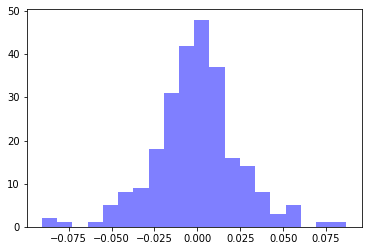

In [24]:
x = Stock_return[['Portfolio_log_return']].values
#print(x)

plt.hist(x, 20, facecolor='blue', alpha=0.5)
plt.show()


In [25]:
#calculate new portfolio value
#stocks_qty = {'WB': 200, 'NFLX': 300, 'F':250, 'RDSA':150}
print(float(WB[WB['Date']== '2019-03-01'].iloc[:, 5]))
V_pf2 = float(WB[WB['Date']== '2019-03-01'].iloc[:, 5])*200 \
        + float(NFLX[NFLX['Date']== '2019-03-01'].iloc[:, 5])*300 \
        + float(F[F['Date']== '2019-03-01'].iloc[:, 5])*250 \
        + float(RDSA[RDSA['Date']== '2019-03-01'].iloc[:, 5])*150
print(V_pf2)
#new portfolio value starting 1st March $132763.8423

72.07
132762.8423


In [26]:
#calculate new weights based on price on 1st March 2019
s_weight2 = dict()
s_weight2['WB'] = float(WB[WB['Date']== '2019-03-01'].iloc[:, 5])*200/V_pf2
s_weight2['NFLX'] = float(NFLX[NFLX['Date']== '2019-03-01'].iloc[:, 5])*300/V_pf2
s_weight2['F'] = float(F[F['Date']== '2019-03-01'].iloc[:, 5])*250/V_pf2
s_weight2['RDSA'] = float(RDSA[RDSA['Date']== '2019-03-01'].iloc[:, 5])*150/V_pf2

print(s_weight)
print(sum(s_weight.values()))

{'WB': 0.1120047760974533, 'NFLX': 0.8049631814848014, 'F': 0.015912182458893833, 'RDSA': 0.0671198599588514}
0.9999999999999999


In [27]:
# Create a new dataset with log-returns of 4 stocks
dfs = [WB, NFLX, F, RDSA]
Stock_return_6M = reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)
Stock_return_6M = Stock_return[['Date','WB_log_return','NFLX_log_return','F_log_return','RDSA_log_return']]
Stock_return_6M  = Stock_return_6M[Stock_return_6M['Date']>= '2019-03-01'].reset_index()
Stock_return_6M.dropna(inplace=True)
Stock_return_6M.drop(columns=['index'], inplace=True)
Stock_return_6M.head(n=10)

,Date,WB_log_return,NFLX_log_return,F_log_return,RDSA_log_return
0,2019-03-01,-0.002494,-0.002181,0.002278,0.001767
1,2019-03-04,0.004154,-0.017732,0.002273,-0.000481
2,2019-03-05,-0.037305,0.009244,-0.004551,0.001444
3,2019-03-06,-0.035476,0.014876,-0.021903,0.000160
4,2019-03-07,-0.079944,-0.019686,-0.011723,-0.013230
5,2019-03-08,-0.009381,-0.008545,-0.007101,-0.012585
6,2019-03-11,0.043561,0.026143,0.022315,0.007048
7,2019-03-12,-0.016153,-0.007243,-0.004657,0.001795
8,2019-03-13,-0.012729,0.013771,-0.004678,0.026544
9,2019-03-14,-0.017282,-0.006639,-0.014168,0.000952


In [28]:
Stock_return_6M['Portfolio_log_return'] = s_weight2['WB'] * Stock_return_6M['WB_log_return'] \
                                       + s_weight2['NFLX']* Stock_return_6M['NFLX_log_return'] \
                                       + s_weight2['F']* Stock_return_6M['F_log_return'] \
                                       + s_weight2['RDSA'] * Stock_return_6M['RDSA_log_return'] 
Stock_return_6M.head()

,Date,WB_log_return,NFLX_log_return,F_log_return,RDSA_log_return,Portfolio_log_return
0,2019-03-01,-0.002494,-0.002181,0.002278,0.001767,-0.001875
1,2019-03-04,0.004154,-0.017732,0.002273,-0.000481,-0.013863
2,2019-03-05,-0.037305,0.009244,-0.004551,0.001444,0.003440
3,2019-03-06,-0.035476,0.014876,-0.021903,0.000160,0.007825
4,2019-03-07,-0.079944,-0.019686,-0.011723,-0.013230,-0.025662


In [29]:
VaR_portfolio_6M = Stock_return_6M['Portfolio_log_return'].quantile([0.01])
VaR_portfolio_value_6M = Stock_return_6M['Portfolio_log_return'].quantile([0.01])*V_pf2
print("portfolio value using 6 months data is: " + str(V_pf2))#updated
print("portfolio VaR in % using 6 months data is: " + str(float(VaR_portfolio_6M)*-1))
print("portfolio VaR in $ using 6 months data is: " + str(float(VaR_portfolio_value_6M)*-1))

portfolio value using 6 months data is: 132762.8423
portfolio VaR in % using 6 months data is: 0.041920594040359034
portfolio VaR in $ using 6 months data is: 5565.497215702506


In [30]:
#Question 6
alpha = 0.01
z_square = norm.ppf(alpha, loc=0, scale=1)**2
numer = np.exp(-z_square/2)
denom = ((math.pi*2)**0.5)*alpha
es=weighted_mean + volatility*numer/denom
es_pf = es*V_pf 
print("Expected shortfall using parametric approach is: $" + str(float(es_pf)))


Expected shortfall using parametric approach is: $8839.195588279408


## HW1 Part 2 = Yield Curve, Spot Rates

In [84]:
# Read US Treasury yields data
GOV = pd.read_csv("GovBond.csv")
GOV

,Maturity,Coupon Rate,Yield,Price
0,1,0,1.50,98.522167
1,2,1.25%,1.66,99.199975
2,3,3.00%,1.67,103.860352
3,4,2.88%,1.75,104.328965
4,5,3.38%,1.87,107.144257
5,6,2.38%,1.95,102.412685
6,7,2.75%,2.10,104.190670


In [85]:
GOV = GOV.sort_values(['Maturity'], ascending=True) #sort according to maturity first
GOV['indexer'] = [i for i in range(len(GOV))]
GOV['Coupon'] = [float(i[:-1]) if i != '0' else 0 for i in GOV['Coupon Rate']]
#cannot convert string to float is string is '0', for the 1st row
GOV

,Maturity,Coupon Rate,Yield,Price,indexer,Coupon
0,1,0,1.50,98.522167,0,0.00
1,2,1.25%,1.66,99.199975,1,1.25
2,3,3.00%,1.67,103.860352,2,3.00
3,4,2.88%,1.75,104.328965,3,2.88
4,5,3.38%,1.87,107.144257,4,3.38
5,6,2.38%,1.95,102.412685,5,2.38
6,7,2.75%,2.10,104.190670,6,2.75


In [92]:
def calc_spot_rate(df):
    '''This function is used to calculate spot rate (or zero-coupon rate) for each maturity.
    Inputs:
    1) df: Original dataframe
    
    Outputs:
    1) df: Updated dataframe   
    
    '''
    
    for index in range(df.shape[0]):
        print(index)
        if df.loc[index, 'Coupon'] == 0:
            # spot rate for zero-coupon bond equals to yield rate
            df.loc[index, 'Spot'] == df.loc[index, 'Yield']
            
        else:
            print(f"Working on index {index} ")
            
            price = df.loc[index, 'Price'] # present value
            print(f"Original price {price} ")
            coupon = df.loc[index, 'Coupon'] # semi-annual coupon
            for t in range(index):
                print(f"Coupon is {coupon}")
                print(f"Spot rate to discount {1+df.loc[t, 'Spot']/100} with period {t+1}")
                print(1+df.loc[t, 'Spot']/100)
                print(f"Price = {price} - {coupon} / ({(1+df.loc[t, 'Spot']/100)}**{(t+1)})")
                price = price - coupon / ((1+df.loc[t, 'Spot']/100)**(t+1))
                print(f"Intermediate price = {price}")
                
            print(f"Final Price of {index} period bond is {price}")
            # Calculate spot rate
            df.loc[index, 'Spot'] = (((100+coupon)/price)**(1/(index+1)) - 1)*100 
            #note maturity = 2 years, is stored at index =1, but previous term need power 1, its inde is 0 so need tp index + 1
            print(f"Spot rate of {index+1} period bond is { df.loc[index, 'Spot']}")

In [93]:
GOV['Spot'] = GOV['Yield']
calc_spot_rate(GOV)
GOV

0
1
Working on index 1 
Original price 99.19997528 
Coupon is 1.25
Spot rate to discount 1.015 with period 1
1.015
Price = 99.19997528 - 1.25 / (1.015**1)
Intermediate price = 97.96844818640395
Final Price of 1 period bond is 97.96844818640395
Spot rate of 2 period bond is 1.6610056447914134
2
Working on index 2 
Original price 103.86035240000001 
Coupon is 3.0
Spot rate to discount 1.015 with period 1
1.015
Price = 103.86035240000001 - 3.0 / (1.015**1)
Intermediate price = 100.90468737536946
Coupon is 3.0
Spot rate to discount 1.0166100564479141 with period 2
1.0166100564479141
Price = 100.90468737536946 - 3.0 / (1.0166100564479141**2)
Intermediate price = 98.00191854021675
Final Price of 2 period bond is 98.00191854021675
Spot rate of 3 period bond is 1.6718866030675184
3
Working on index 3 
Original price 104.32896509999999 
Coupon is 2.88
Spot rate to discount 1.015 with period 1
1.015
Price = 104.32896509999999 - 2.88 / (1.015**1)
Intermediate price = 101.49152667635467
Coupon is 

,Maturity,Coupon Rate,Yield,Price,indexer,Coupon,Spot
0,1,0,1.50,98.522167,0,0.00,1.500000
1,2,1.25%,1.66,99.199975,1,1.25,1.661006
2,3,3.00%,1.67,103.860352,2,3.00,1.671887
3,4,2.88%,1.75,104.328965,3,2.88,1.754811
4,5,3.38%,1.87,107.144257,4,3.38,1.882645
5,6,2.38%,1.95,102.412685,5,2.38,1.962300
6,7,2.75%,2.10,104.190670,6,2.75,2.125035


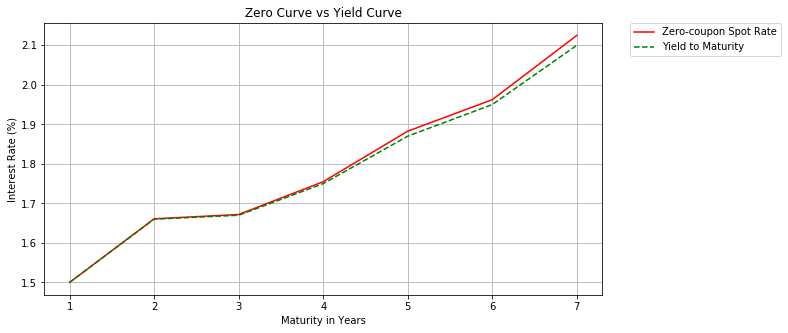

In [103]:
plt.figure(figsize=(10, 5))
plt.grid(True)
plt.plot(GOV['Maturity'], GOV['Spot'], 'r-', label='Zero-coupon Spot Rate')
plt.plot(GOV['Maturity'], GOV['Yield'], 'g--', label='Yield to Maturity')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Zero Curve vs Yield Curve")
plt.ylabel("Interest Rate (%)")
plt.xlabel("Maturity in Years")
plt.show()

Q7b) Plot the forward curve, yield and spot rate curves on the same graph. 
Note: in the tutorial, the code was written to calculate a 6 month forward. In this case, the data and forward curve do not need to be de-annualized. Also, note there is a difference in the term structure (i.e. the tutorial starts with a bond with a maturity of 3 months, but not the assignment). The code will have to be amended to account for these differences. 


In [99]:
def calc_1_year_forward_rate(df):
    '''This function is used to calculate spot rate (or zero-coupon rate) for each maturity.
    Inputs:
    1) df: Original dataframe
    2) yr: How many years forward
    
    Outputs:
    1) df: Updated dataframe   
    
    '''
    
    name = str(1)+'year_'+'forward'
    df[name] = np.nan 
  
    for index in range(1,df.shape[0]-1):
        
        spot_fyr = df.loc[index+1, 'Spot'] # Spot rate of 1 period later
        #print(f"Period # is {index}")
        #print(f"Period ahead spot discount is {spot_fyr/100}") 
        
        spot = df.loc[index, 'Spot'] # Spot rate currently
        #print(f"Current spot is {spot/100}")
        effect_spot_fyr = (1+spot_fyr/100)**(index+1) # Compound by deannualized spot rate for n+1 periods
        #print(f"Eff spot fyr is {(1+spot_fyr/100)} ** {index+1}  = {effect_spot_fyr}")
        
        effect_spot = (1+spot/100)**(index) # Compound by deannualized spot rate for n periods
        #print(f"Eff spot is {(1+spot/100)}** {(index)} = {effect_spot} = ")

        #print(f"Effect_spot_fyr/Effect_spot = {effect_spot_fyr}/{effect_spot} = {effect_spot_fyr/effect_spot}") 
        #the forward rate is the spot rate for n+1 periods compounded over n+1 period divided by 
        #spot rate for n periods compounded over n periods - as formula for forward (refer to slides!)
        forward = 200 * ((effect_spot_fyr / effect_spot) - 1)
        #print(f"Effect_spot_fyr/Effect_spot = {effect_spot_fyr}/{effect_spot} = {effect_spot_fyr/effect_spot}") 
        df.loc[index, name] = forward
        
        #print spot_fyr, spot, effect_spot_fyr, effect_spot, forward

In [100]:
calc_1_year_forward_rate(GOV)
GOV

,Maturity,Coupon Rate,Yield,Price,indexer,Coupon,Spot,1year_forward
0,1,0,1.50,98.522167,0,0.00,1.500000,NaN
1,2,1.25%,1.66,99.199975,1,1.25,1.661006,3.365537
2,3,3.00%,1.67,103.860352,2,3.00,1.671887,3.841724
3,4,2.88%,1.75,104.328965,3,2.88,1.754811,4.534223
4,5,3.38%,1.87,107.144257,4,3.38,1.882645,4.563087
5,6,2.38%,1.95,102.412685,5,2.38,1.962300,5.885232
6,7,2.75%,2.10,104.190670,6,2.75,2.125035,NaN


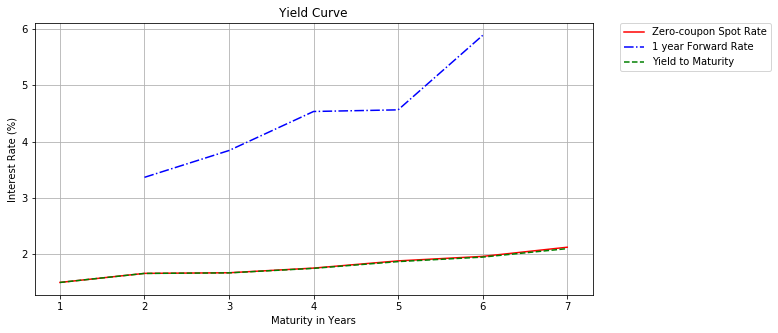

In [101]:
plt.figure(figsize=(10, 5))
plt.grid(True)
plt.plot(GOV['Maturity'], GOV['Spot'], 'r-', label='Zero-coupon Spot Rate')
plt.plot(GOV['Maturity'], GOV['1year_forward'], 'b-.', label='1 year Forward Rate')
plt.plot(GOV['Maturity'], GOV['Yield'], 'g--', label='Yield to Maturity')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Yield Curve")
plt.ylabel("Interest Rate (%)")
plt.xlabel("Maturity in Years")
plt.show()